In [6]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd

def get_note_freq(p):
    """
    Return the frequency corresponding to a particular
    note number
    Parameters
    ----------
    p: int
        Note number, in halfsteps.  0 is a concert a
    """
    return 440*2**(p/12)

def load_tune(filename, tune_length):
    """
    Load in information about notes and their
    onset times from a text file
    Parameters
    ----------
    filename: string
        Path to file with the tune
    tune_length: float
        Length, in seconds, of the tune
    
    Returns
    -------
    ps: ndarray(N)
        A list of N note numbers
    times: ndarray(N)
        Duration of each note, in increments
        of sixteenth notes
    """
    tune = np.loadtxt(filename)
    ps = tune[:, 0]
    times = np.zeros(tune.shape[0])
    times[1::] = np.cumsum(tune[0:-1, 1])
    times = times*tune_length/np.sum(tune[:, 1])
    return ps, times

def do_risset_slow(filename, tune_length, freqs_per_note, sr):
    """
    Implement the naive version of Risset beats where 
    freqs_per_note sinusoids are added for every note
    Parameters
    ----------
    filename: string
        Path to file with the tune
    tune_length: float
        Length, in seconds, of the tune
    freqs_per_note: int
        Number of frequencies to use for each note
    sr: int
        The sample rate of the entire piece
    """
    
    ps, onset = load_tune(filename, tune_length)
    ts = np.arange(int(tune_length*sr))/sr
    y = np.zeros_like(ts)
    num_notes = len(ps)
    # sinusoid function = y(x) = cos(2*pi*f*t)
    for i in range(num_notes): #for loop to generate the note
        f = get_note_freq(ps[i])
        y += np.cos(2*np.pi*f*ts) #base freq
        for j in range(freqs_per_note):
            f = get_note_freq(ps[i])+(0.2*j) #to create the frequency that will beat with the base frequencies
            phi = 2*np.pi*f*onset[i] #2pi times the freq times the offset
            t = ts
            y += np.cos(2*np.pi*f*t-phi)
    return y


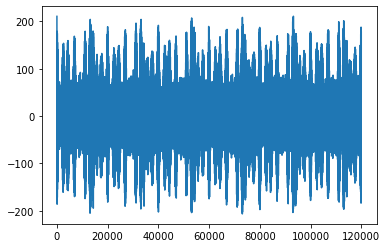

In [8]:
tune_length = 15
freqs_per_note = 50
sr = 8000
x = do_risset_slow("Tunes/mytune.txt", tune_length, freqs_per_note, sr)
plt.plot(x)
ipd.Audio(x, rate=sr)

In [31]:
def do_risset_fast(filename, tune_length, freqs_per_note, sr):
    """
    Implement the faster version of Risset beats that aggregates
    duplicate frequencies into a sine and cosine term
    Parameters
    ----------
    filename: string
        Path to file with the tune
    tune_length: float
        Length, in seconds, of the tune
    freqs_per_note: int
        Number of frequencies to use for each note
    sr: int
        The sample rate of the entire piece
    """
    ps, onset = load_tune(filename, tune_length)
    ts = np.arange(int(tune_length*sr))/sr
    y = np.zeros_like(ts)
    cos_dict = {}
    sin_dict = {}
    for p, ons in zip(ps, onset):
        f = get_note_freq(p)
        for i in range(freqs_per_note): #primary loop for song
            if f not in cos_dict:
                cos_dict[f] = 0 #intializes the dictionary values for cosine
            if f not in sin_dict:
                sin_dict[f] = 0 #initializes the dictionary values for sin
            cos_dict[f] += np.cos(2*np.pi*f*ons) #populates the cos dictionary at key f
            sin_dict[f] += np.cos(2*np.pi*f*ons) #populares the sin dictionary at key f
            f+= 1/tune_length #then f iterates by a factor of 1/tune_length such that it will eventually equal tune_length
    for freq in cos_dict:
        y+= (cos_dict[freq]*np.cos(2*np.pi*freq*ts))+(sin_dict[freq]*np.cos(2*np.pi*freq*ts)) #populates y (since cos and sin dictionaries are the same number of elements)
    return y

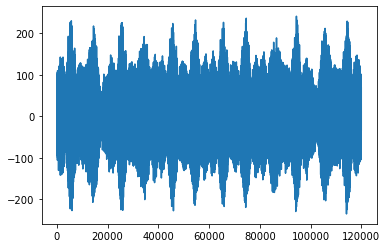

In [36]:
tune_length = 15
freqs_per_note = 50
sr = 8000
x = do_risset_fast("Tunes/mytune.txt", tune_length, freqs_per_note, sr)
plt.plot(x)
ipd.Audio(x, rate=sr)